In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

### 加载训练数据和测试数据

In [3]:
data_path = "./Data/"
train_df = pd.read_csv(data_path + 'mitbih_train.csv',header=None)
test_df = pd.read_csv(data_path + 'mitbih_test.csv',header=None)

### 打印训练标签

In [4]:
# Assuming the target column is the last column
target_column_index = train_df.shape[1] - 1

# Get the unique values in the target column
class_labels = train_df[target_column_index].unique()

# Assign meaningful names to the class labels based on domain knowledge
class_names = {
    0: "Normal Beats",
    1: "Supraventricular Ectopy Beats",
    2: "Ventricular Ectopy Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

# Print class labels with their assigned names
for label in class_labels:
    print(f"Class label {label}: {class_names[label]}")

Class label 0.0: Normal Beats
Class label 1.0: Supraventricular Ectopy Beats
Class label 2.0: Ventricular Ectopy Beats
Class label 3.0: Fusion Beats
Class label 4.0: Unclassifiable Beats


### 统计训练样本和测试样本不同类别个数

In [5]:
train_df[187]=train_df[187].astype(float)
equilibre = train_df[187].value_counts()
print(equilibre)

print("\n")

test_df[187]=test_df[187].astype(float)
equilibre = test_df[187].value_counts()
print(equilibre)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


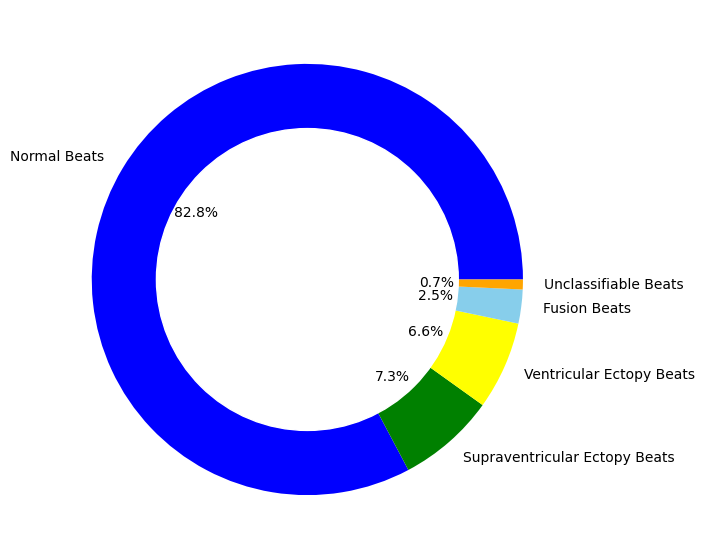

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64
5


In [6]:
plt.figure(figsize=(14,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')

labels_= ['Normal Beats','Supraventricular Ectopy Beats','Ventricular Ectopy Beats','Fusion Beats','Unclassifiable Beats']
plt.pie(equilibre, labels=labels_, colors=['Blue','Green','Yellow','Skyblue','Orange'],autopct='%1.1f%%', textprops={'color': 'black'})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

print(train_df[187].value_counts())
print(len(train_df[187].value_counts()))

In [7]:
X_train = train_df.drop(columns = [187])
y_train = train_df[187]

# Split the training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
# Separate features and target variable for test dataset
X_test = test_df.drop(columns=[187])
y_test = test_df[187]

In [21]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Create the SVM classifier
svm_classifier = svm.SVC(kernel='rbf', random_state=42)

# Train the classifier on the normalized training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the normalized validation set
y_pred_valid = svm_classifier.predict(X_valid)

# Calculate accuracy on the validation set
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

# Make predictions on the normalized test set
y_pred_test = svm_classifier.predict(X_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

Validation Accuracy: 0.9681914225344069
Test Accuracy: 0.9670655947378037


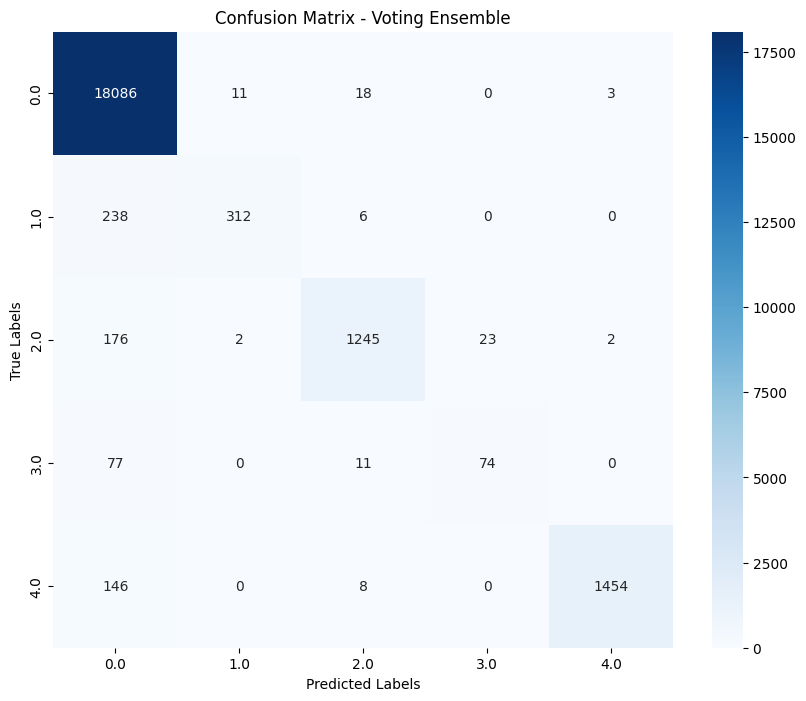

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Voting Ensemble')
plt.show()

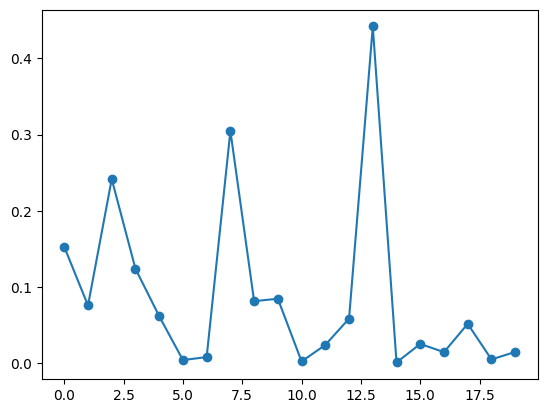

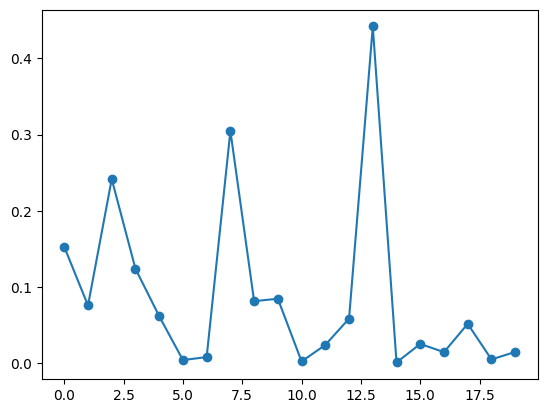

Epoch 20, Loss: 0.014975257217884064


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from IPython.display import clear_output

import numpy as np


''' 
自定义数据集，需要定义好‘__getitem__’函数
'''
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

class FNNModel(nn.Module):
    def __init__(self):
        super(FNNModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(187, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.output_layer = nn.Linear(512, 5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output_layer(x)
        return x

# 模型训练步骤
def train_model(model, dataloader, criterion, optimizer, num_epochs=20):
    model.train()
    model.to(device)  # Move the model to the device (GPU or CPU)
    
    # 初始化用于绘图的损失列表
    loss_values = []
    
    # 设置实时更新图的基础配置
    plt.figure(figsize=(10, 5))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    
    for epoch in range(num_epochs):
        for data, labels in dataloader:
            # print(epoch)
            if device.type == 'cuda':
                data, labels = data.to(device), labels.to(device)  # Move data and labels to the device
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # 记录当前epoch的损失
        loss_values.append(loss.item())
        
        # 动态更新图表
        clear_output(wait=True)
        plt.plot(loss_values, label='Training Loss', marker='o')
        # plt.legend()
        display(plt.gcf())
        plt.pause(0.01)  # 暂停一点时间以便更新图表
        
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# 构造数据集
data, labels = X_train, y_train
data = np.array(data)
print(data.shape)

# Convert data and labels to PyTorch tensors
data = torch.tensor(data, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Create dataset and dataloader
dataset = CustomDataset(data, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# 创建模型
model = FNNModel()

# 打印模型结构
# print(model)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Train your model
train_model(model, dataloader, criterion, optimizer, num_epochs=20)